# Operationalizing Epistemic Uncertainty via Deep Kernel Reinforcement Learning

This notebook on Deep Kernel Learning related to computer vision tasks is made possible by [GPyTorch](https://docs.gpytorch.ai/en/v1.6.0/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html). Please refer to the embedded link for more details and the original GitHub page tutorial.

## What is SV-DKL?

SV-DKL stands for "Stochastic Variational Deep Kernel Learning." Think of it like combining two ideas:

- A deep neural network that learns useful features (feature extractor) from raw inputs (images, text, etc.).
- A Gaussian Process (GP), which is a way to make predictions with a notion of uncertainty (uncertainty of knowledge).

SV-DKL feeds the neural network's learned features into an approximation (for scalability) of a GP. That gives you powerful pattern learning from deep nets plus uncertainty estimates from GPs. It makes the model better at saying "I don't know" for unfamiliar inputs. This is useful for safety, active learning, and detecting when a model is likely to be wrong.

**SV-DKL = deep learning (for features) + Gaussian Processes (for uncertainty).**

# Part 0: Libraries

In [ ]:
# Run this line if not already installed
!pip install gpytorch

In [ ]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
import torch
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
import gpytorch
import math
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch
import numpy as np
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Data Processing

With our packages installed, let's begin loading in our data. We will use CIFAR-10 (in distribution) and CIFAR-100 (out of distribution) with data augmentations.

In [ ]:
import torch
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler

# --- 1. Transforms ---
# Applied to BOTH CIFAR-10 and CIFAR-100 to prevent "shortcut learning"
train_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# --- 2. Custom Dataset Wrapper ---
class RiskAwareDataset(Dataset):
    def __init__(self, cifar10_data, cifar100_data):
        self.cifar10 = cifar10_data
        self.cifar100 = cifar100_data
        self.c10_len = len(cifar10_data)
        self.c100_len = len(cifar100_data)

    def __len__(self):
        return self.c10_len + self.c100_len

    def __getitem__(self, idx):
        if idx < self.c10_len:
            # In-Distribution (CIFAR-10): Return Label 0-9, Flag=0
            img, label = self.cifar10[idx]
            return img, label, 0
        else:
            # Out-of-Distribution (CIFAR-100): Return Label -1, Flag=1
            img, label = self.cifar100[idx - self.c10_len]
            return img, -1, 1

# --- 3. Load Raw Data ---
print("Loading Datasets...")
c10_train_full = dset.CIFAR10(root='data', train=True, transform=train_transform, download=True)
c10_test_full = dset.CIFAR10(root='data', train=False, transform=test_transform, download=True)

c100_train_full = dset.CIFAR100(root='data', train=True, transform=train_transform, download=True)
c100_test_full = dset.CIFAR100(root='data', train=False, transform=test_transform, download=True)

# --- 4. Create Splits ---
# A. DKL Splits (Pure CIFAR-10)
# 50k Total -> 45k for DKL (leaving 5k for RL), then split 45k -> 40k Train / 5k Val
dkl_full_set, rl_id_train_set = random_split(c10_train_full, [45000, 5000])
dkl_train_set, dkl_val_set = random_split(dkl_full_set, [40000, 5000])

# B. Validation & Test Splits (Mixed)
c10_val, c10_final = random_split(c10_test_full, [1000, 9000])
c100_val, c100_final = random_split(c100_test_full, [1000, 9000])

# C. RL Datasets (Mixed)
rl_train_dataset = RiskAwareDataset(rl_id_train_set, c100_train_full) # 5k ID + 50k OOD
rl_val_dataset = RiskAwareDataset(c10_val, c100_val)                  # 1k ID + 1k OOD
final_test_dataset = RiskAwareDataset(c10_final, c100_final)          # 9k ID + 9k OOD

# --- 5. Balancing Logic (Crucial for RL) ---
count_id = len(rl_id_train_set)     # ~5,000
count_ood = len(c100_train_full)    # ~50,000
total_count = count_id + count_ood

# Weights: Inverse probability to ensure 50/50 sampling
weight_id = 1.0 / count_id
weight_ood = 1.0 / count_ood
sample_weights = [weight_id] * count_id + [weight_ood] * count_ood
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(sample_weights, num_samples=total_count, replacement=True)

# --- 6. DataLoaders ---
# DKL Loaders (For SVDKL Training)
dkl_train_loader = DataLoader(dkl_train_set, batch_size=256, shuffle=True, num_workers=2)
dkl_val_loader   = DataLoader(dkl_val_set,   batch_size=256, shuffle=False, num_workers=2)

# RL Loaders (For Agent Training)
# balanced_rl_loader uses the sampler, so shuffle MUST be False
balanced_rl_loader = DataLoader(rl_train_dataset, batch_size=1, sampler=sampler, num_workers=2)
rl_val_loader      = DataLoader(rl_val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader        = DataLoader(final_test_dataset, batch_size=1, shuffle=False, num_workers=2)

print("\n--- Data Pipeline Ready ---")
print(f"DKL Train: {len(dkl_train_set)} (Pure ID)")
print(f"DKL Val:   {len(dkl_val_set)} (Pure ID)")
print(f"RL Train:  {len(rl_train_dataset)} (Mixed, Balanced Sampling Active)")
print(f"Final Test:{len(final_test_dataset)} (Mixed, ~50/50 Natural Split)")

Loading Datasets...

--- Data Pipeline Ready ---
DKL Train: 40000 (Pure ID)
DKL Val:   5000 (Pure ID)
RL Train:  55000 (Mixed, Balanced Sampling Active)
Final Test:18000 (Mixed, ~50/50 Natural Split)


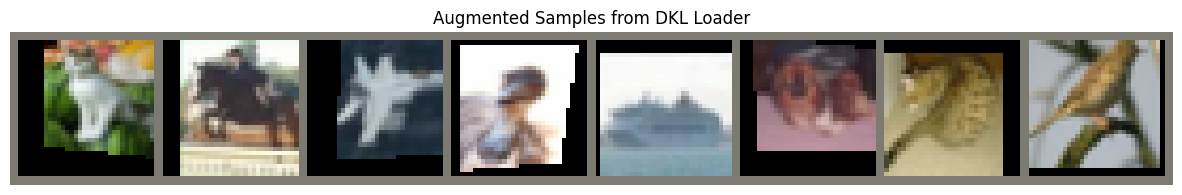

cat   horse plane bird  ship  dog   cat   bird 


In [ ]:
# Helper function to un-normalize and display
def imshow(img, title=None):
    # (These are the standard CIFAR-10 mean/std)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    # Move to CPU and un-normalize
    img = img.cpu()
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # Clip values to [0, 1] to avoid matplotlib warnings for any slight overflows
    img = torch.clamp(img, 0, 1)

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
# dkl_loader is batch_size=256, so we just show a grid of the first few
dataiter = iter(dkl_train_loader)
images, labels = next(dataiter)

# Show top 8 images
plt.figure(figsize=(15, 5))
imshow(torchvision.utils.make_grid(images[:8], padding=2), title="Augmented Samples from DKL Loader")
plt.show()

# Print labels to verify (0-9)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# Part 2: Feature Extractor

With our data out of the way, let's define our neural network feature extractor. The output of the feature extractor is a latent embedding space. This latent space will then be processed by the GP layer. For simplicity, we will use a DenseNet to get started quickly.

In [ ]:
class DenseNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load base DenseNet model
        base_model = torchvision.models.densenet121()

        # Save only the feature extractor part (everything except the classifier)
        self.features = base_model.features
        self.avgpool_size = 7

        # Store the classifier in_features so we know the feature dimension
        self.num_features = base_model.classifier.in_features

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        return out

# Example: instantiate feature extractor
feature_extractor = DenseNetFeatureExtractor()
num_features = feature_extractor.num_features
print("Output feature dimension:", num_features)

Output feature dimension: 1024


# Part 3: GP Layer

Now we'll implement the GP output layer. This layer will use the outputs from the feature extractor and assign one GP per feature. [Per the paper](https://arxiv.org/pdf/1611.00336):

> **Model Training**
>
> For our deep kernel learning model, we used deep neural networks which produce $C$-dimensional top-level features. Here $C$ is the number of classes. We place a Gaussian process on each dimension of these features. We used RBF base kernels. The additive GP layer is then followed by a linear mixing layer $A \in \mathbb{R}^{C × C}$. We initialized $A$ to be an identity matrix, and optimized in the joint learning procedure to recover cross-dimension correlations from data.

In other words, if we naïvely put one independent GP per class, we don't get any sharing between classes, and there's a good chance they'll overfit.

The solution is to put a latent GP on each dimension (in this case 1024 latent GPs) and combine these independent GPs together into a mixing matrix $A$ so that they can share information.

In [ ]:
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )

        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        # We wrap it with a IndependentMultitaskVariationalStrategy so that our output is a vector-valued GP
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Part 4: SVDKL Composition

With both a feature extractor and GP definition set up, let's now define our SVDKL model composition. The goal is to:
1. Output a latent embedding space from the feature extractor;
2. Pass latent information into the GP layer so that each GP can model a latent feature dimension;
3. Evaluate all GPs to get a vector of latent GP outputs;
4. Utilize the mixing layer to produce class logits as a weighted sum of all 1024 GP outputs;
5. Compute a softmax from logits and output classification.

In [ ]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res

num_classes = 10
model = DKLModel(feature_extractor, num_dim=num_features)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=num_classes)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Part 5: Baseline Softmax Classifier

In [ ]:
# --- 1. Define Standard DenseNet (FROM SCRATCH) ---
class StandardDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(StandardDenseNet, self).__init__()
        # Load architecture structure ONLY, no weights
        self.net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

        # Replace head for CIFAR-10
        num_ftrs = self.net.classifier.in_features
        self.net.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.net(x)

# Part 6: Training

The training is fairly straight-forward. We train for a pre-determined number of epochs, and save the model which has the highest validation accuracy. Unlike the paper, where they utilize a pretrained DenseNet, we are training from scratch to get a better idea of how the model performs holistically starting from the ground up. The model then updates both NN weights and GP hyperparameters through Stochastic Variational Inference (SVI).

Note: SVI is just performing SGD to maximize the evidence lower bound (ELBO) loss function. Why? The goal of maximizing the ELBO is because it is equivalent to minimizing the KL divergence, which is necessary to approximate a relatively tight parameterized distribution to the true posterior distribution.

### DKL Training

In [ ]:
# --- 1. Training Params ---
n_epochs = 50
lr = 0.05
optimizer = torch.optim.SGD([
    {'params': model.feature_extractor.parameters(), 'weight_decay': 1e-4},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
], lr=lr, momentum=0.9, nesterov=True, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)

# Evidence Lower Bound (ELBO)
mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(dkl_train_loader.dataset))

# Metrics
train_losses = []
val_accuracies = []
best_accuracy = -1
best_epoch = 0

# --- 2. Train Function ---
def train(epoch):
    model.train()
    likelihood.train()

    running_loss = 0.0
    print() # formatting line space
    minibatch_iter = tqdm.tqdm(dkl_train_loader, desc=f"(Epoch {epoch}) Minibatch")

    with gpytorch.settings.num_likelihood_samples(8):
        for data, target in minibatch_iter:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)

            loss = -mll(output, target)
            loss.backward()
            optimizer.step()

            # Accumulate scalar value (.item()) to save memory
            running_loss += loss.item()
            minibatch_iter.set_postfix(loss=loss.item())

    # Record average training loss
    epoch_avg_loss = running_loss / len(dkl_train_loader)
    train_losses.append(epoch_avg_loss)
    print(f'Train set: Average loss: {epoch_avg_loss:.4f}')

# --- 3. Validation Function ---
def validation():
    model.eval()
    likelihood.eval()

    correct = 0
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in dkl_val_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = likelihood(model(data))
            pred = output.probs.mean(0).argmax(-1)
            correct += pred.eq(target.view_as(pred)).cpu().sum()

    # Comput accuracy
    val_accuracy = 100. * correct / float(len(dkl_val_loader.dataset))
    val_accuracies.append(val_accuracy)

    print(f'Validation set: Accuracy: {correct}/{len(dkl_val_loader.dataset)} ({val_accuracy:.2f}%)')
    return val_accuracy

# --- 4. Main Loop ---
print(f"Starting training on {len(dkl_train_loader.dataset)} images, validating on {len(dkl_val_loader.dataset)}...")

for epoch in range(1, n_epochs + 1):
    with gpytorch.settings.use_toeplitz(False):
        train(epoch)
        val_acc = validation()

    scheduler.step()

    # Model checkpointing
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_epoch = epoch

        # Save model state
        state_dict = model.state_dict()
        likelihood_state_dict = likelihood.state_dict()
        torch.save({
            'epoch': epoch,
            'model': state_dict,
            'likelihood': likelihood_state_dict,
            'optimizer': optimizer.state_dict(),
            'accuracy': best_accuracy
        }, 'dkl_cifar_chkpt_best.pt')

        print(f"--> New best model (Epoch {epoch}) saved!")

print("Training Complete!")
print(f"Best validation accuracy found at epoch {best_epoch}: {best_accuracy:.2f}%")

Starting training on 40000 images, validating on 5000...


(Epoch 1) Minibatch: 100%|██████████| 157/157 [00:45<00:00,  3.45it/s, loss=2.32]

Train set: Average loss: 2.3352


Validation set: Accuracy: 502/5000 (10.04%)
--> New best model (Epoch 1) saved!


(Epoch 2) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s, loss=2.31]

Train set: Average loss: 2.3319


Validation set: Accuracy: 890/5000 (17.80%)
--> New best model (Epoch 2) saved!


(Epoch 3) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.71it/s, loss=2.08]

Train set: Average loss: 2.0979


Validation set: Accuracy: 983/5000 (19.66%)
--> New best model (Epoch 3) saved!


(Epoch 4) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.75it/s, loss=1.99]

Train set: Average loss: 1.9209


Validation set: Accuracy: 1467/5000 (29.34%)
--> New best model (Epoch 4) saved!


(Epoch 5) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s, loss=1.76]


Train set: Average loss: 1.7299
Validation set: Accuracy: 1896/5000 (37.92%)
--> New best model (Epoch 5) saved!


(Epoch 6) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=1.55]

Train set: Average loss: 1.5442


Validation set: Accuracy: 2319/5000 (46.38%)
--> New best model (Epoch 6) saved!


(Epoch 7) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s, loss=1.49]

Train set: Average loss: 1.5197


Validation set: Accuracy: 2405/5000 (48.10%)
--> New best model (Epoch 7) saved!


(Epoch 8) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.76it/s, loss=1.16]

Train set: Average loss: 1.3455


Validation set: Accuracy: 2666/5000 (53.32%)
--> New best model (Epoch 8) saved!


(Epoch 9) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.76it/s, loss=1.22]

Train set: Average loss: 1.2286


Validation set: Accuracy: 2546/5000 (50.92%)


(Epoch 10) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s, loss=1.43]

Train set: Average loss: 1.1689


Validation set: Accuracy: 2951/5000 (59.02%)
--> New best model (Epoch 10) saved!


(Epoch 11) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.74it/s, loss=0.904]

Train set: Average loss: 1.0546


Validation set: Accuracy: 3123/5000 (62.46%)
--> New best model (Epoch 11) saved!


(Epoch 12) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.66it/s, loss=1.16]

Train set: Average loss: 0.9876


Validation set: Accuracy: 3141/5000 (62.82%)
--> New best model (Epoch 12) saved!


(Epoch 13) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.71it/s, loss=1.23]


Train set: Average loss: 0.9391
Validation set: Accuracy: 3334/5000 (66.68%)
--> New best model (Epoch 13) saved!


(Epoch 14) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.74it/s, loss=1.29]

Train set: Average loss: 0.8756


Validation set: Accuracy: 2523/5000 (50.46%)


(Epoch 15) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s, loss=1.09]

Train set: Average loss: 0.8872


Validation set: Accuracy: 3469/5000 (69.38%)
--> New best model (Epoch 15) saved!


(Epoch 16) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=1.13]

Train set: Average loss: 0.8219


Validation set: Accuracy: 2991/5000 (59.82%)


(Epoch 17) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s, loss=0.671]

Train set: Average loss: 0.8131


Validation set: Accuracy: 3069/5000 (61.38%)


(Epoch 18) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.74it/s, loss=0.941]

Train set: Average loss: 0.7816


Validation set: Accuracy: 3570/5000 (71.40%)
--> New best model (Epoch 18) saved!


(Epoch 19) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.62]

Train set: Average loss: 0.7169


Validation set: Accuracy: 3649/5000 (72.98%)
--> New best model (Epoch 19) saved!


(Epoch 20) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.78it/s, loss=0.918]


Train set: Average loss: 0.6920
Validation set: Accuracy: 1889/5000 (37.78%)


(Epoch 21) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=1.3]

Train set: Average loss: 1.0488


Validation set: Accuracy: 3483/5000 (69.66%)


(Epoch 22) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.638]

Train set: Average loss: 0.7714


Validation set: Accuracy: 3527/5000 (70.54%)


(Epoch 23) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s, loss=0.803]

Train set: Average loss: 0.7098


Validation set: Accuracy: 3659/5000 (73.18%)
--> New best model (Epoch 23) saved!


(Epoch 24) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s, loss=0.758]

Train set: Average loss: 0.6682


Validation set: Accuracy: 3753/5000 (75.06%)
--> New best model (Epoch 24) saved!


(Epoch 25) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s, loss=0.777]

Train set: Average loss: 0.6307


Validation set: Accuracy: 3720/5000 (74.40%)


(Epoch 26) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.75it/s, loss=0.91]

Train set: Average loss: 0.6108


Validation set: Accuracy: 3676/5000 (73.52%)


(Epoch 27) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s, loss=0.49]

Train set: Average loss: 0.5915


Validation set: Accuracy: 3784/5000 (75.68%)
--> New best model (Epoch 27) saved!


(Epoch 28) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s, loss=0.41]

Train set: Average loss: 0.5682


Validation set: Accuracy: 3832/5000 (76.64%)
--> New best model (Epoch 28) saved!


(Epoch 29) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s, loss=0.541]

Train set: Average loss: 0.5468


Validation set: Accuracy: 3753/5000 (75.06%)


(Epoch 30) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s, loss=0.653]

Train set: Average loss: 0.5419


Validation set: Accuracy: 3854/5000 (77.08%)
--> New best model (Epoch 30) saved!


(Epoch 31) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s, loss=0.526]

Train set: Average loss: 0.4534


Validation set: Accuracy: 4038/5000 (80.76%)
--> New best model (Epoch 31) saved!


(Epoch 32) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.678]

Train set: Average loss: 0.4163


Validation set: Accuracy: 4008/5000 (80.16%)


(Epoch 33) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s, loss=0.498]

Train set: Average loss: 0.4050


Validation set: Accuracy: 4046/5000 (80.92%)
--> New best model (Epoch 33) saved!


(Epoch 34) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s, loss=0.546]

Train set: Average loss: 0.3996


Validation set: Accuracy: 4091/5000 (81.82%)
--> New best model (Epoch 34) saved!


(Epoch 35) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.452]

Train set: Average loss: 0.3859


Validation set: Accuracy: 4081/5000 (81.62%)


(Epoch 36) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.78it/s, loss=0.406]

Train set: Average loss: 0.3828


Validation set: Accuracy: 4102/5000 (82.04%)
--> New best model (Epoch 36) saved!


(Epoch 37) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.78it/s, loss=0.563]

Train set: Average loss: 0.3748


Validation set: Accuracy: 4045/5000 (80.90%)


(Epoch 38) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s, loss=0.495]

Train set: Average loss: 0.3733


Validation set: Accuracy: 4076/5000 (81.52%)


(Epoch 39) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.74it/s, loss=0.518]

Train set: Average loss: 0.3673


Validation set: Accuracy: 4062/5000 (81.24%)


(Epoch 40) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s, loss=0.378]

Train set: Average loss: 0.3597


Validation set: Accuracy: 4044/5000 (80.88%)


(Epoch 41) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.334]

Train set: Average loss: 0.3521


Validation set: Accuracy: 4071/5000 (81.42%)


(Epoch 42) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.447]


Train set: Average loss: 0.3507
Validation set: Accuracy: 4082/5000 (81.64%)


(Epoch 43) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s, loss=0.252]


Train set: Average loss: 0.3427
Validation set: Accuracy: 4064/5000 (81.28%)


(Epoch 44) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s, loss=0.288]

Train set: Average loss: 0.3384


Validation set: Accuracy: 4072/5000 (81.44%)


(Epoch 45) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.75it/s, loss=0.218]

Train set: Average loss: 0.3360


Validation set: Accuracy: 4105/5000 (82.10%)
--> New best model (Epoch 45) saved!


(Epoch 46) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.212]

Train set: Average loss: 0.3236


Validation set: Accuracy: 4091/5000 (81.82%)


(Epoch 47) Minibatch: 100%|██████████| 157/157 [00:43<00:00,  3.65it/s, loss=0.345]

Train set: Average loss: 0.3214


Validation set: Accuracy: 4122/5000 (82.44%)
--> New best model (Epoch 47) saved!


(Epoch 48) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s, loss=0.265]

Train set: Average loss: 0.3212


Validation set: Accuracy: 4123/5000 (82.46%)
--> New best model (Epoch 48) saved!


(Epoch 49) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s, loss=0.452]

Train set: Average loss: 0.3164


Validation set: Accuracy: 4098/5000 (81.96%)


(Epoch 50) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.72it/s, loss=0.348]

Train set: Average loss: 0.3146


Validation set: Accuracy: 4085/5000 (81.70%)


(Epoch 51) Minibatch: 100%|██████████| 157/157 [00:42<00:00,  3.74it/s, loss=0.401]

Train set: Average loss: 0.3176


Validation set: Accuracy: 4064/5000 (81.28%)


(Epoch 52) Minibatch: 100%|██████████| 157/157 [00:43<00:00,  3.65it/s, loss=0.467]

Train set: Average loss: 0.3207


Validation set: Accuracy: 4092/5000 (81.84%)


(Epoch 53) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s, loss=0.519]

Train set: Average loss: 0.3135


Validation set: Accuracy: 4080/5000 (81.60%)


(Epoch 54) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.28]

Train set: Average loss: 0.3089


Validation set: Accuracy: 4093/5000 (81.86%)


(Epoch 55) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.90it/s, loss=0.299]

Train set: Average loss: 0.3083


Validation set: Accuracy: 4113/5000 (82.26%)


(Epoch 56) Minibatch: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s, loss=0.181]

Train set: Average loss: 0.3115


Validation set: Accuracy: 4063/5000 (81.26%)


(Epoch 57) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.305]

Train set: Average loss: 0.3096


Validation set: Accuracy: 4113/5000 (82.26%)


(Epoch 58) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s, loss=0.375]

Train set: Average loss: 0.3119


Validation set: Accuracy: 4116/5000 (82.32%)


(Epoch 59) Minibatch: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s, loss=0.19]

Train set: Average loss: 0.3080


Validation set: Accuracy: 4091/5000 (81.82%)


(Epoch 60) Minibatch: 100%|██████████| 157/157 [00:39<00:00,  3.94it/s, loss=0.48]

Train set: Average loss: 0.3072


Validation set: Accuracy: 4085/5000 (81.70%)
Training Complete!
Best validation accuracy found at epoch 48: 82.46%


### Baseline Training

In [ ]:
# --- 2. Rigorous Training Loop (Matching SVDKL) ---
def train_baseline(train_loader, val_loader, epochs=50):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = StandardDenseNet(num_classes=10).to(device)

    # Use standard CIFAR-10 training params (SGD + Momentum + Decay)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    # Cosine Annealing is standard for modern CIFAR training
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    print(f"Training Fair Baseline (From Scratch) for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        # Training Step
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()

        # Validation Step
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

            print(f"Epoch {epoch+1}: Train Acc: {100.*correct/total:.2f}% | Val Acc: {100.*val_correct/val_total:.2f}%")

    return model

# --- EXECUTION ---
# Train the baseline using the exact same DKL training loader (Pure ID)
# This ensures it sees the EXACT same data as your SVDKL model.
fair_baseline = train_baseline(dkl_train_loader, dkl_val_loader, epochs=n_epochs)

# Save it so you don't have to retrain
torch.save(fair_baseline.state_dict(), 'fair_baseline_cifar10.pth')
print("Fair Baseline Trained & Saved!")

# Part 6.5: Loading Model Checkpoint

With training completed, we now load our best performing model for inference experiments.

In [ ]:
# Load best model checkpoint
dkl_model = DKLModel(feature_extractor, num_dim=num_features)
checkpoint = torch.load('dkl_cifar_chkpt_best.pt')
dkl_model.load_state_dict(checkpoint['model'])
likelihood.load_state_dict(checkpoint['likelihood'])

# Ensure model and likelihood are on the correct device
if torch.cuda.is_available():
    dkl_model = dkl_model.cuda()
    likelihood = likelihood.cuda()

print("Best model checkpoint loaded successfully!")

# Unpack fair baseline
softmax_baseline = StandardDenseNet(num_classes=10).to('cuda')
softmax_baseline.load_state_dict(torch.load('fair_baseline_cifar10.pth'))

Best model checkpoint loaded successfully!


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

# Part 7: Risk Management Agent

While standard classification minimizes a smooth loss function (like Cross Entropy), RL allows you to optimize a non-differentiable, discrete reward function. You want your model to make a strategic decision: "Is it worth guessing and risking a mistake, or should I fold?"

In other words, by treating this as an RL Bandits problem, the agent learns a Policy ($\pi$) -- distinct behaviors that a simple threshold can't capture. For example, it might learn:
- "If Mutual Information is high (OOD), always Abstain."
- "If Mutual Information is low (I know the data) but Entropy is high (the image is blurry/ambiguous), Abstain."
- "If I am 60% sure it's a Cat, but the penalty for being wrong is huge, I will Abstain."

The general setup is as follows:
1. **State ($S$)**: The input to the agent is the output from SVDKL and Baseline Softmax Classifier.
    - State vector = [Class_Logits, Predictive_Entropy, Mutual_Information, Softmax Prob]

2. **Actions ($A$)**: The agent has 2 actions:
    - Abstain
    - Commit (to prediction)

3. **Reward ($R$)**: ---------------------- CHANGE THIS LATER
    - Correct Prediction
    - Incorrect Prediction
    - Abstain
        - Correct abstain (OOD)
        - Incorrect abstain (ID)

## 7.1 Environment

In [ ]:
import gym
from gym import spaces
import numpy as np
import torch
import gpytorch

class RiskAwareCIFAR_Hybrid(gym.Env):
    def __init__(self, dkl_model, likelihood, baseline_model, data_loader, device='cuda', computation_cost=0.5):
        super(RiskAwareCIFAR_Hybrid, self).__init__()

        self.dkl_model = dkl_model
        self.likelihood = likelihood
        self.baseline_model = baseline_model
        self.loader = data_loader
        self.device = device
        self.iterator = iter(self.loader)

        # Action Space: 0=Softmax, 1=DKL, 2=Abstain
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-10.0, high=2.0, shape=(4,), dtype=np.float32)

        # Stats for normalization
        self.mean = np.array([0.95, 0.9, -1.0, -2.5], dtype=np.float32)
        self.std  = np.array([0.05, 0.1,  1.0,  1.0], dtype=np.float32)

        self.dkl_cost = computation_cost

        # Cache variables
        self.current_img = None
        self.current_label = None
        self.current_dkl_probs = None
        self.current_base_probs = None
        self.is_ood = False

        self.dkl_model.eval()
        self.likelihood.eval()
        self.baseline_model.eval()

    def step(self, action):
        reward = 0
        outcome_str = ""

        # Retrieve predictions for checking "Savior" status
        base_pred = np.argmax(self.current_base_probs)
        dkl_pred = np.argmax(self.current_dkl_probs)

        # --- ACTION 2: ABSTAIN ---
        if action == 2:
            if self.is_ood:
                reward = +10
                outcome_str = "Safe_OOD"
            else:
                # Penalize ID Abstention harder to force coverage?
                # Let's keep -100 for now, but you can increase to -150 to reduce caution.
                reward = -100
                outcome_str = "Lazy_ID"

        # --- ACTION 0: COMMIT SOFTMAX ---
        elif action == 0:
            if self.is_ood:
                reward = -75
                outcome_str = "Hazard_OOD"
            else:
                if base_pred == self.current_label:
                    reward = +100
                    outcome_str = "Correct_Base"
                else:
                    reward = -20
                    outcome_str = "Miss_Base"

        # --- ACTION 1: COMMIT DKL (The "Savior" Logic) ---
        elif action == 1:
            # Apply standard compute cost
            reward -= self.dkl_cost

            if self.is_ood:
                reward -= 75 # Hazard
                outcome_str = "Hazard_OOD"
            else:
                if dkl_pred == self.current_label:
                    # BASE REWARD
                    reward += 100

                    # --- THE SPECIALIST BONUS ---
                    # If Softmax was WRONG here, DKL is a Hero.
                    if base_pred != self.current_label:
                        reward += 50 # Bonus! Total = 150
                        outcome_str = "Savior_DKL"
                    else:
                        outcome_str = "Correct_DKL"
                else:
                    reward -= 20
                    outcome_str = "Miss_DKL"

        info = {
            'is_ood': bool(self.is_ood),
            'outcome': outcome_str,
            'action_type': int(action)
        }

        done = True
        next_obs = self.reset()
        return next_obs, reward, done, info

    def reset(self):
        try:
            batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            batch = next(self.iterator)

        images, labels, ood_flags = batch
        self.current_img = images.to(self.device)
        self.current_label = labels.item()
        self.is_ood = (ood_flags.item() == 1)

        with torch.no_grad():
            # 1. BASELINE
            base_out = self.baseline_model(self.current_img)
            base_probs = torch.softmax(base_out, dim=1)
            base_max_prob, _ = base_probs.max(dim=1)
            self.current_base_probs = base_probs.cpu().numpy().flatten()

            # 2. SVDKL
            with gpytorch.settings.num_likelihood_samples(16):
                output = self.likelihood(self.dkl_model(self.current_img))
                probs_samples = output.probs
                mean_probs = probs_samples.mean(0)
                self.current_dkl_probs = mean_probs.cpu().numpy().flatten()

                eps = 1e-10
                pred_entropy = -torch.sum(mean_probs * torch.log(mean_probs + eps), dim=-1)
                entropy_per_sample = -torch.sum(probs_samples * torch.log(probs_samples + eps), dim=-1)
                expected_entropy = entropy_per_sample.mean(0)
                mutual_info = pred_entropy - expected_entropy
                dkl_max_prob = mean_probs.max()

            # 3. State Vector
            raw_state = np.array([
                base_max_prob.item(),
                dkl_max_prob.item(),
                np.log10(pred_entropy.item() + 1e-6),
                np.log10(mutual_info.item() + 1e-6)
            ], dtype=np.float32)

            obs = (raw_state - self.mean) / (self.std + 1e-6)

        return obs

## 7.2 DQN

### Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

# --- 1. The Q-Network ---
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingQNetwork, self).__init__()

        # 1. Common Feature Layer
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # 2. Value Stream (V): Estimates the value of the state itself
        # Output dim is 1 (Scalar value of being in this state)
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # 3. Advantage Stream (A): Estimates advantage of each action
        # Output dim is action_dim (Relative value of each button)
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)

        values = self.value_stream(features)
        advantages = self.advantage_stream(features)

        # Recombine: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        # This normalization trick helps stability
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values

# --- 2. Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

### Training

In [ ]:
# --- Training Loop ---
def train_dqn(env, num_episodes=5000, batch_size=256, gamma=0.99, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Networks
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = DuelingQNetwork(state_dim, action_dim).to(device)
    target_net = DuelingQNetwork(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=20000)

    # Epsilon Decay Strategy
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = num_episodes * 0.4 # Decay over first 40% of episodes

    all_rewards = []
    losses = []

    # Tracking action distribution: [Softmax, DKL, Abstain]
    action_history = []

    for episode in range(num_episodes):
        state = env.reset()

        # Standard exponential decay
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                  np.exp(-1. * episode / (epsilon_decay / 5))

        # Action Selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = policy_net(state_t)
                action = q_values.argmax().item()

        # Step
        next_state, reward, done, info = env.step(action)

        # Store for visualization
        all_rewards.append(reward)
        action_history.append(action)

        buffer.push(state, action, reward, next_state, done)
        state = next_state # Not strictly necessary as done=True, but good practice

        # --- Training Step ---
        if len(buffer) > batch_size:
            transitions = buffer.sample(batch_size)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

            b_state = torch.FloatTensor(np.array(batch_state)).to(device)
            b_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
            b_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            b_next_state = torch.FloatTensor(np.array(batch_next_state)).to(device)
            b_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            # Current Q
            curr_q = policy_net(b_state).gather(1, b_action)

            # Target Q (Double DQN logic is safer, but standard is fine here)
            with torch.no_grad():
                next_q = target_net(b_next_state).max(1)[0].unsqueeze(1)
                target_q = b_reward + (gamma * next_q * (1 - b_done))

            loss = F.smooth_l1_loss(curr_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())

        # Update Target Network
        if episode % 500 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Logging
        if episode % 1000 == 0 or episode == num_episodes - 1:
            avg_rew = np.mean(all_rewards[-100:])
            # Calculate % of each action in last 100 steps
            recent_actions = action_history[-100:]
            act_counts = {x: recent_actions.count(x) for x in range(3)}
            print(f"Ep {episode} | Avg R: {avg_rew:.1f} | Softmax: {act_counts.get(0,0)}% | DKL: {act_counts.get(1,0)}% | Abstain: {act_counts.get(2,0)}%")

    return policy_net, all_rewards, action_history


# --- 4. Run Training ---
env = RiskAwareCIFAR_Hybrid(dkl_model, likelihood, softmax_baseline, balanced_rl_loader)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn_agent = DuelingQNetwork(state_dim=state_dim, action_dim=action_dim).to('cuda')
dqn_agent, rewards, action_history = train_dqn(env)

Ep 0 | Avg R: 10.0 | Softmax: 0% | DKL: 0% | Abstain: 1%
Ep 1000 | Avg R: 21.5 | Softmax: 45% | DKL: 8% | Abstain: 47%
Ep 2000 | Avg R: 17.6 | Softmax: 48% | DKL: 3% | Abstain: 49%
Ep 3000 | Avg R: 25.3 | Softmax: 52% | DKL: 1% | Abstain: 47%
Ep 4000 | Avg R: 24.6 | Softmax: 44% | DKL: 9% | Abstain: 47%
Ep 4999 | Avg R: 25.7 | Softmax: 53% | DKL: 2% | Abstain: 45%


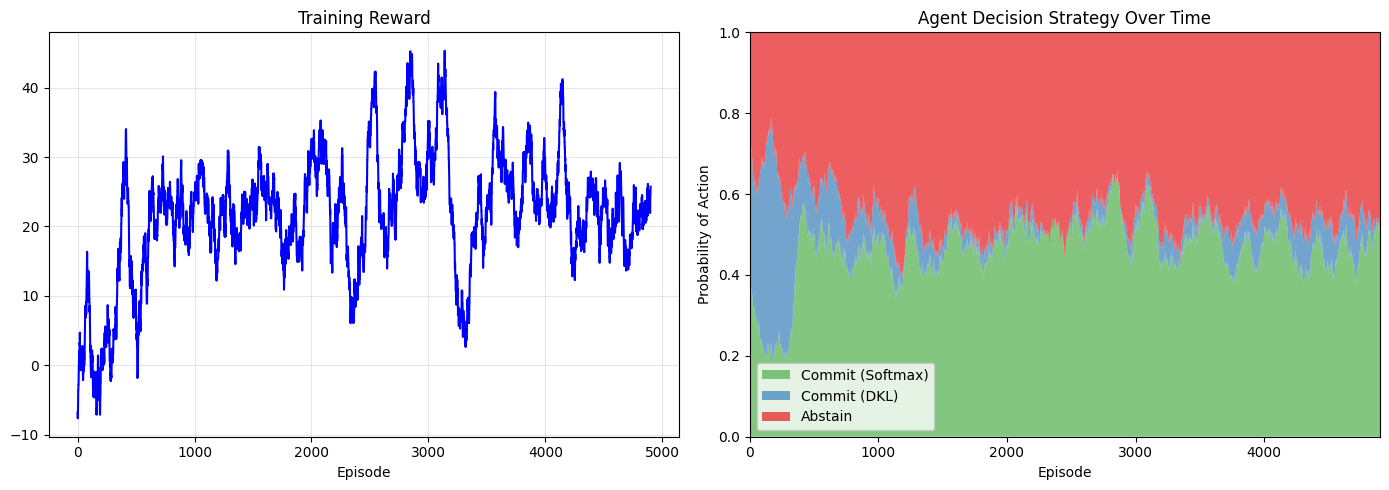

In [ ]:
window = 100

plt.figure(figsize=(14, 5))

# 1. Moving Average Reward
plt.subplot(1, 2, 1)
ma_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(ma_rewards, color='blue', label='Avg Reward')
plt.title("Training Reward")
plt.xlabel("Episode")
plt.grid(True, alpha=0.3)

# 2. Action Distribution (Stacked Area Chart)
plt.subplot(1, 2, 2)

# Convert list of actions to one-hot-like density over time
# This creates a "rolling percentage" for each action type
series_0 = [1 if x==0 else 0 for x in action_history]
series_1 = [1 if x==1 else 0 for x in action_history]
series_2 = [1 if x==2 else 0 for x in action_history]

ma_0 = np.convolve(series_0, np.ones(window)/window, mode='valid')
ma_1 = np.convolve(series_1, np.ones(window)/window, mode='valid')
ma_2 = np.convolve(series_2, np.ones(window)/window, mode='valid')

x_axis = range(len(ma_0))

plt.stackplot(x_axis, ma_0, ma_1, ma_2,
              labels=['Commit (Softmax)', 'Commit (DKL)', 'Abstain'],
              colors=['#4daf4a', '#377eb8', '#e41a1c'], alpha=0.7)

plt.title("Agent Decision Strategy Over Time")
plt.xlabel("Episode")
plt.ylabel("Probability of Action")
plt.legend(loc='lower left')
plt.margins(0,0)

plt.tight_layout()
plt.show()

Save the RL Agent

In [ ]:
torch.save(dqn_agent.state_dict(), "risk_aware_dqn_agent.pt")
print("RL Agent saved!")

RL Agent saved!


# Part 8: Evaluation

## 8.1 Numerical Results

In [ ]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
import gpytorch
from tqdm import tqdm

def evaluate_hybrid_agent(dkl_model, likelihood, baseline_model, agent, dataloader, device='cuda'):
    dkl_model.eval()
    likelihood.eval()
    baseline_model.eval()
    agent.eval()

    # Stats for normalization (Must match training!)
    mean_stats = torch.tensor([0.95, 0.9, -1.0, -2.5], device=device)
    std_stats  = torch.tensor([0.05, 0.1,  1.0,  1.0], device=device)

    all_logs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Meta-Controller Eval"):
            images, labels, ood_flags = batch
            images, labels, ood_flags = images.to(device), labels.to(device), ood_flags.to(device)

            # 1. Baseline Probs
            base_out = baseline_model(images)
            base_probs = torch.softmax(base_out, dim=1)
            base_max_probs, base_preds = base_probs.max(dim=1) # <--- Capturing base_preds

            # 2. DKL Probs
            with gpytorch.settings.num_likelihood_samples(16):
                output = likelihood(dkl_model(images))
                probs_samples = output.probs
            mean_probs = probs_samples.mean(0)
            dkl_max_probs, dkl_preds = mean_probs.max(dim=1)   # <--- Capturing dkl_preds

            # Metrics
            eps = 1e-10
            pred_entropy = -torch.sum(mean_probs * torch.log(mean_probs + eps), dim=-1)
            entropy_per_sample = -torch.sum(probs_samples * torch.log(probs_samples + eps), dim=-1)
            expected_entropy = entropy_per_sample.mean(0)
            mutual_info = pred_entropy - expected_entropy

            # 3. Agent Decision
            raw_state = torch.stack([
                base_max_probs,
                dkl_max_probs,
                torch.log10(pred_entropy + 1e-6),
                torch.log10(mutual_info + 1e-6)
            ], dim=1)

            state_batch = (raw_state - mean_stats) / (std_stats + 1e-6)
            q_values = agent(state_batch)
            actions = q_values.argmax(dim=1)

            # 4. Selective Prediction Logic
            chosen_preds = torch.where(actions == 1, dkl_preds, base_preds)

            # --- LOGGING EVERYTHING ---
            batch_logs = pd.DataFrame({
                'entropy': pred_entropy.cpu().numpy(),
                'mutual_info': mutual_info.cpu().numpy(),
                'action': actions.cpu().numpy(),
                'is_ood': ood_flags.cpu().numpy(),
                'label': labels.cpu().numpy(),
                'chosen_pred': chosen_preds.cpu().numpy(),
                'base_conf': base_max_probs.cpu().numpy(),
                'dkl_conf': dkl_max_probs.cpu().numpy(),
                'base_pred': base_preds.cpu().numpy(),
                'dkl_pred': dkl_preds.cpu().numpy()
            })
            all_logs.append(batch_logs)

    df = pd.concat(all_logs, ignore_index=True)
    return df


# RUN EVALUATION
fast_eval_loader = DataLoader(
    final_test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2
)

# Load dqn agent
dqn_agent = DuelingQNetwork(state_dim=4, action_dim=3).to('cuda')
dqn_agent.load_state_dict(torch.load("risk_aware_dqn_agent.pt"))
df_results = evaluate_hybrid_agent(
    dkl_model, likelihood, softmax_baseline, dqn_agent, fast_eval_loader
)

Meta-Controller Eval: 100%|██████████| 71/71 [00:04<00:00, 15.19it/s]


In [ ]:
def check_q_values(env, agent, n=10):
    agent.eval()
    print(f"{'State Type':<15} | {'Predicted Q (Commit)':<20} | {'Predicted Q (Abstain)':<20} | {'Choice'}")
    print("-" * 70)

    for _ in range(n):
        obs = env.reset()
        is_ood = env.is_ood # Access internal state for debug

        with torch.no_grad():
            state_t = torch.FloatTensor(obs).unsqueeze(0).to('cuda')
            q_vals = agent(state_t)
            action = q_vals.argmax().item()

        print(f"{'OOD' if is_ood else 'ID':<15} | {q_vals[0][0]:.4f}               | {q_vals[0][1]:.4f}                | {action}")

# Run it
check_q_values(env, dqn_agent)

State Type      | Predicted Q (Commit) | Predicted Q (Abstain) | Choice
----------------------------------------------------------------------
ID              | 95.0957               | 92.5751                | 0
OOD             | -77.4383               | -77.7993                | 2
ID              | 99.7685               | 99.2957                | 0
OOD             | -76.7236               | -77.8634                | 2
OOD             | -74.5003               | -78.2597                | 2
ID              | -39.0197               | -43.2233                | 0
ID              | 100.3914               | 100.1794                | 0
ID              | 100.2347               | 100.0103                | 0
OOD             | 63.7219               | 63.0971                | 0
ID              | 100.5561               | 100.2086                | 0


In [ ]:
import pandas as pd
import numpy as np

def detailed_confusion_matrix_hybrid(df):
    print("="*70)
    print("META-CONTROLLER GRANULAR DIAGNOSTICS")
    print("="*70)

    # --- 1. Define Categories ---
    # Action 0 = Commit (Softmax)
    # Action 1 = Commit (DKL)
    # Action 2 = Abstain

    # TP: OOD caught (Action 2 on OOD data)
    TP = ((df['is_ood'] == 1) & (df['action'] == 2)).sum()

    # TN: ID correctly processed (Action 0 or 1 on ID data)
    # Note: We consider ANY commit (0 or 1) on ID data as a "Negative" (Non-Abstain)
    TN = ((df['is_ood'] == 0) & (df['action'] != 2)).sum()

    # FP: ID rejected (Action 2 on ID data) - "False Alarm"
    FP = ((df['is_ood'] == 0) & (df['action'] == 2)).sum()

    # FN: OOD missed (Action 0 or 1 on OOD data) - "Hazard"
    FN = ((df['is_ood'] == 1) & (df['action'] != 2)).sum()

    total = len(df)

    print(f"{'Category':<25} | {'Count':<8} | {'Description'}")
    print("-" * 70)
    print(f"{'True Positives (TP)':<25} | {TP:<8} | OOD safely Abstained.")
    print(f"{'True Negatives (TN)':<25} | {TN:<8} | ID accepted (by either expert).")
    print(f"{'False Positives (FP)':<25} | {FP:<8} | ID rejected (Over-cautious).")
    print(f"{'False Negatives (FN)':<25} | {FN:<8} | OOD accepted (Hazardous).")
    print("-" * 70)

    # --- 2. Derived Metrics ---
    print("\n[Global Safety Metrics]")
    sensitivity = TP / (TP + FN) if (TP+FN) > 0 else 0 # OOD Detection Rate
    specificity = TN / (TN + FP) if (TN+FP) > 0 else 0 # ID Coverage Rate
    precision   = TP / (TP + FP) if (TP+FP) > 0 else 0 # Precision of Abstention

    print(f"OOD Detection Rate (Sensitivity): {sensitivity*100:.2f}%")
    print(f"ID Coverage Rate (Specificity):   {specificity*100:.2f}%")
    print(f"Abstain Precision:                {precision*100:.2f}%  (Are abstains actually OOD?)")

    # --- 3. Expert Usage Breakdown (New Section) ---
    print("\n[Expert Usage Breakdown (ID Data Only)]")
    id_data = df[df['is_ood'] == 0]
    total_commits = len(id_data[id_data['action'] != 2])

    if total_commits > 0:
        use_softmax = len(id_data[id_data['action'] == 0])
        use_dkl     = len(id_data[id_data['action'] == 1])

        print(f"Softmax Usage: {use_softmax} ({use_softmax/total_commits:.1%})")
        print(f"DKL Usage:     {use_dkl} ({use_dkl/total_commits:.1%})")

        # Accuracy of each expert WHEN CHOSEN
        # Note: We use 'chosen_pred' which we computed in evaluation
        acc_softmax = id_data[(id_data['action'] == 0) & (id_data['chosen_pred'] == id_data['label'])].shape[0] / use_softmax if use_softmax else 0
        acc_dkl     = id_data[(id_data['action'] == 1) & (id_data['chosen_pred'] == id_data['label'])].shape[0] / use_dkl if use_dkl else 0

        print(f"Softmax Accuracy (When Chosen): {acc_softmax:.1%}")
        print(f"DKL Accuracy (When Chosen):     {acc_dkl:.1%}")
    else:
        print("No ID data committed.")

    # --- 4. The "Why is ID Coverage Low?" Analysis ---
    print("\n[DIAGNOSIS: Why are we rejecting ID data?]")
    print("Comparing 'Accepted ID' (Action 0/1) vs 'Rejected ID' (Action 2)...")

    accepted_id = id_data[id_data['action'] != 2]
    rejected_id = id_data[id_data['action'] == 2]

    if len(accepted_id) > 0 and len(rejected_id) > 0:
        print(f"{'Metric':<15} | {'Accepted ID':<18} | {'Rejected ID (FP)':<18} | {'Gap'}")
        print("-" * 65)
        for metric in ['entropy', 'mutual_info', 'base_conf', 'dkl_conf']:
            # Handle potential missing columns if old logs used
            if metric in df.columns:
                mu_acc = accepted_id[metric].mean()
                mu_rej = rejected_id[metric].mean()
                print(f"{metric:<15} | {mu_acc:.4f}             | {mu_rej:.4f}             | {mu_rej - mu_acc:+.4f}")

        print("\nINTERPRETATION:")
        print("-> High 'entropy' Gap: Rejection is justified (Input was confusing).")
        print("-> Low 'entropy' Gap:  Rejection is paranoid (Agent is too timid).")
    else:
        print("Not enough data to compare groups.")

# Usage
detailed_confusion_matrix_hybrid(df_results)

META-CONTROLLER GRANULAR DIAGNOSTICS
Category                  | Count    | Description
----------------------------------------------------------------------
True Positives (TP)       | 6738     | OOD safely Abstained.
True Negatives (TN)       | 6598     | ID accepted (by either expert).
False Positives (FP)      | 2402     | ID rejected (Over-cautious).
False Negatives (FN)      | 2262     | OOD accepted (Hazardous).
----------------------------------------------------------------------

[Global Safety Metrics]
OOD Detection Rate (Sensitivity): 74.87%
ID Coverage Rate (Specificity):   73.31%
Abstain Precision:                73.72%  (Are abstains actually OOD?)

[Expert Usage Breakdown (ID Data Only)]
Softmax Usage: 6344 (96.2%)
DKL Usage:     254 (3.8%)
Softmax Accuracy (When Chosen): 96.4%
DKL Accuracy (When Chosen):     85.8%

[DIAGNOSIS: Why are we rejecting ID data?]
Comparing 'Accepted ID' (Action 0/1) vs 'Rejected ID' (Action 2)...
Metric          | Accepted ID        | Rejec

In [ ]:
def analyze_id_performance_hybrid(df):
    print("="*60)
    print("IN-DISTRIBUTION (ID) DEEP DIVE - HYBRID AGENT")
    print("="*60)

    # Filter for ID data only
    id_data = df[df['is_ood'] == 0]
    total_id = len(id_data)

    # 1. Broad Actions
    # Action 2 is Abstain
    n_abstain = (id_data['action'] == 2).sum()

    # Actions 0 and 1 are Commits
    n_commit  = (id_data['action'] != 2).sum()

    # 2. Prediction Quality (Of those we committed to)
    # We use 'chosen_pred', which contains the prediction of the EXPERT the agent selected
    committed_data = id_data[id_data['action'] != 2]

    n_correct = committed_data[committed_data['chosen_pred'] == committed_data['label']].shape[0]
    n_wrong   = committed_data[committed_data['chosen_pred'] != committed_data['label']].shape[0]

    # 3. Sub-analysis: Which expert got it right?
    # Correct via Softmax (Action 0)
    n_cor_soft = id_data[(id_data['action'] == 0) & (id_data['chosen_pred'] == id_data['label'])].shape[0]
    # Correct via DKL (Action 1)
    n_cor_dkl  = id_data[(id_data['action'] == 1) & (id_data['chosen_pred'] == id_data['label'])].shape[0]

    # 4. Percentages
    pct_abstain = (n_abstain / total_id) * 100
    pct_correct = (n_correct / total_id) * 100
    pct_wrong   = (n_wrong / total_id) * 100

    # Conditional Accuracy (When it actually speaks)
    risk_adj_acc = (n_correct / n_commit) * 100 if n_commit > 0 else 0

    print(f"Total ID Images: {total_id}")
    print("-" * 75)
    print(f"{'Category':<30} | {'Count':<8} | {'% of Total':<12} | {'Description'}")
    print("-" * 75)
    print(f"{'Abstained (Caution)':<30} | {n_abstain:<8} | {pct_abstain:<6.2f}%      | Agent refused to guess.")
    print(f"{'Correctly Classified':<30} | {n_correct:<8} | {pct_correct:<6.2f}%      | Agent guessed right.")
    print(f"{'  > via Softmax':<30} | {n_cor_soft:<8} | {(n_cor_soft/total_id)*100:<6.2f}%      | (Fast Expert)")
    print(f"{'  > via DKL':<30} | {n_cor_dkl:<8} | {(n_cor_dkl/total_id)*100:<6.2f}%      | (Robust Expert)")
    print(f"{'Incorrectly Classified':<30} | {n_wrong:<8} | {pct_wrong:<6.2f}%      | Agent guessed wrong.")
    print("-" * 75)
    print(f"Risk-Adjusted Accuracy:   {risk_adj_acc:.2f}% (Accuracy of committed predictions)")

    return n_abstain, n_correct, n_wrong

# Run Analysis
n_abs, n_cor, n_err = analyze_id_performance_hybrid(df_results)

IN-DISTRIBUTION (ID) DEEP DIVE - HYBRID AGENT
Total ID Images: 9000
---------------------------------------------------------------------------
Category                       | Count    | % of Total   | Description
---------------------------------------------------------------------------
Abstained (Caution)            | 2402     | 26.69 %      | Agent refused to guess.
Correctly Classified           | 6331     | 70.34 %      | Agent guessed right.
  > via Softmax                | 6113     | 67.92 %      | (Fast Expert)
  > via DKL                    | 218      | 2.42  %      | (Robust Expert)
Incorrectly Classified         | 267      | 2.97  %      | Agent guessed wrong.
---------------------------------------------------------------------------
Risk-Adjusted Accuracy:   95.95% (Accuracy of committed predictions)


## 8.2 Decision Visualization

In [ ]:
import plotly.graph_objects as go
import numpy as np
import torch

def plot_interactive_safety_ceiling(agent, device='cuda'):
    agent.eval()

    # 1. Define Grid
    # We scan X (Softmax Conf) and Y (DKL Conf)
    softmax_grid = np.linspace(0.5, 1.0, 50)
    dkl_grid = np.linspace(0.5, 1.0, 50)

    # We sweep Z (Entropy) from Low (safe) to High (danger)
    entropy_sweep = np.linspace(-3.0, 1.0, 100) # Expanded range slightly

    X, Y = np.meshgrid(softmax_grid, dkl_grid)

    # Flatten for batch processing
    grid_X = np.repeat(X[:, :, np.newaxis], 100, axis=2).flatten()
    grid_Y = np.repeat(Y[:, :, np.newaxis], 100, axis=2).flatten()
    grid_Z = np.tile(entropy_sweep, 50*50)

    # ASSUMPTION: We fix Mutual Info to a low value (Aleatoric uncertainty focus)
    fixed_mi = np.full_like(grid_X, -2.5)

    # 2. Normalize Inputs (Must match training!)
    norm_base = (grid_X - 0.95) / 0.05
    norm_dkl  = (grid_Y - 0.90) / 0.1
    norm_ent  = (grid_Z - (-1.0)) / 1.0
    norm_mi   = (fixed_mi - (-2.5)) / 1.0

    batch = torch.tensor(np.stack([norm_base, norm_dkl, norm_ent, norm_mi], axis=1), dtype=torch.float32).to(device)

    # 3. Get Decisions
    with torch.no_grad():
        q_values = agent(batch)
        actions = q_values.argmax(dim=1).cpu().numpy()

    # Reshape back to Volume (50 x 50 x 100)
    action_vol = actions.reshape(50, 50, 100)

    # --- CRITICAL FIX ---
    # We want the Z-index where the agent FIRST chooses Action 2 (Abstain)
    # argmax returns the first index where condition is True
    boundary_indices = np.argmax(action_vol == 2, axis=2)

    # Map indices to Entropy values
    Z_surface = entropy_sweep[boundary_indices]

    # Handle cases where it NEVER abstains (Mask them or set to max)
    never_abstained = (np.max(action_vol == 2, axis=2) == False)
    Z_surface[never_abstained] = np.nan # This makes a hole in the plot, which is honest

    # 4. Plotly Visualization
    fig = go.Figure(data=[go.Surface(
        z=Z_surface,
        x=X,
        y=Y,
        colorscale='Viridis', # Yellow=High Entropy allowed, Purple=Strict
        cmin=np.min(entropy_sweep),
        cmax=np.max(entropy_sweep),
        colorbar=dict(title="Max Entropy Allowed"),
        opacity=0.9
    )])

    fig.update_layout(
        title='Agent Safety Boundary (The "Ceiling" of Trust)',
        autosize=False,
        width=900, height=700,
        scene=dict(
            xaxis_title='Baseline Softmax Conf',
            yaxis_title='DKL Max Prob',
            zaxis_title='Max Allowed Log10 Entropy',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
        )
    )
    fig.show()

# Run
plot_interactive_safety_ceiling(dqn_agent)

# Part 9: Baseline Comparisons

Calculating Baseline Curves...
RL Agent -> ID Coverage: 73.31%, OOD Safety: 74.87%


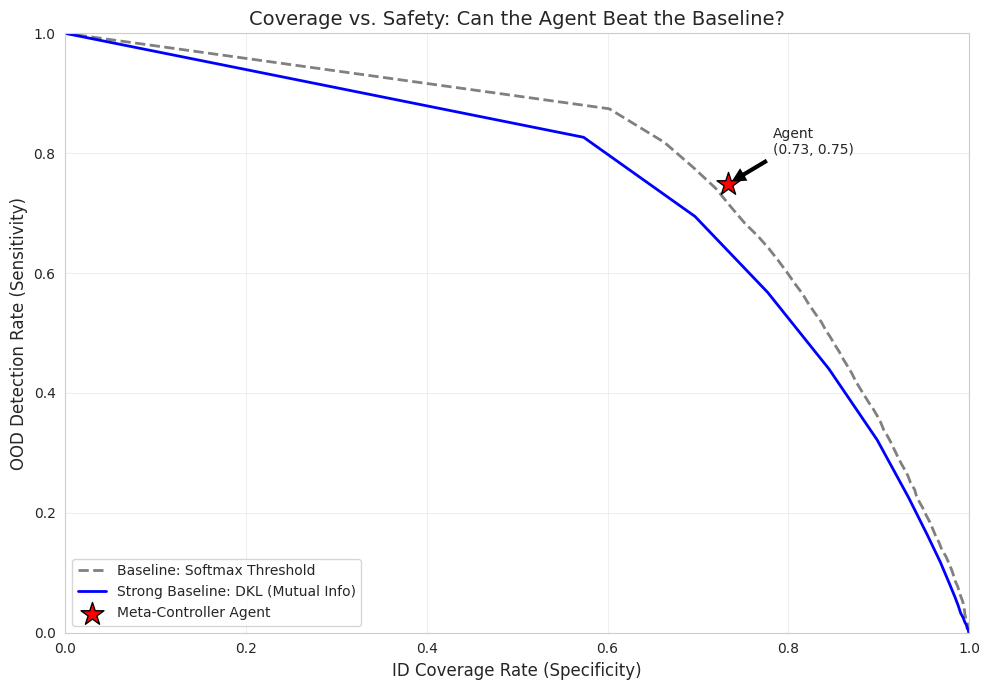

In [ ]:
def get_curve_metrics(model_type, model, loader, likelihood=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    if likelihood: likelihood.eval()

    confidences = []
    correctness = []
    is_ood_list = []

    with torch.no_grad():
        for imgs, labels, ood_flags in loader:
            imgs = imgs.to(device)

            if model_type == 'standard':
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                max_conf, preds = torch.max(probs, dim=1)
                batch_conf = max_conf
                # Note: Labels for OOD are -1, so this will be False (as expected)
                is_correct = (preds.cpu() == labels.cpu()).numpy()

            elif model_type == 'svdkl':
                with gpytorch.settings.num_likelihood_samples(16):
                    output = likelihood(model(imgs))
                    probs_samples = output.probs
                    mean_probs = probs_samples.mean(0)

                    eps = 1e-10
                    pred_entropy = -torch.sum(mean_probs * torch.log(mean_probs + eps), dim=-1)
                    entropy_per_sample = -torch.sum(probs_samples * torch.log(probs_samples + eps), dim=-1)
                    expected_entropy = entropy_per_sample.mean(0)
                    mutual_info = pred_entropy - expected_entropy

                    # Use -MI as confidence (Low MI = High Confidence)
                    batch_conf = -mutual_info
                    _, preds = torch.max(mean_probs, dim=1)
                    is_correct = (preds.cpu() == labels.cpu()).numpy()

            confidences.extend(batch_conf.cpu().numpy())
            is_ood_list.extend(ood_flags.cpu().numpy())
            correctness.extend(is_correct)

    return np.array(confidences), np.array(correctness), np.array(is_ood_list)

def calculate_risk_coverage(confidences, correctness, is_ood, thresholds):
    ood_detection_rates = []
    id_coverage_rates = []
    risk_adj_accuracies = []

    total_ood = (is_ood == 1).sum()
    total_id = (is_ood == 0).sum()

    for t in thresholds:
        # Predict if confidence > t
        predicted_mask = confidences > t
        abstained_mask = ~predicted_mask

        # 1. OOD Detection Rate (Sensitivity)
        if total_ood > 0:
            ood_caught = (abstained_mask & (is_ood == 1)).sum()
            ood_detection_rates.append(ood_caught / total_ood)
        else:
            ood_detection_rates.append(0)

        # 2. ID Coverage (Specificity)
        if total_id > 0:
            id_predicted = (predicted_mask & (is_ood == 0)).sum()
            id_coverage_rates.append(id_predicted / total_id)
        else:
            id_coverage_rates.append(0)

        # 3. Risk-Adjusted Accuracy (on predicted ID)
        mask_id_pred = predicted_mask & (is_ood == 0)
        if mask_id_pred.sum() > 0:
            acc = correctness[mask_id_pred].sum() / mask_id_pred.sum()
            risk_adj_accuracies.append(acc)
        else:
            # If we predict nothing, accuracy is technically undefined,
            # but 1.0 is standard for "no errors made" in these plots.
            risk_adj_accuracies.append(1.0)

    return ood_detection_rates, id_coverage_rates, risk_adj_accuracies


# 1. Get Metrics for Baselines
print("Calculating Baseline Curves...")
conf_std, corr_std, ood_std = get_curve_metrics('standard', fair_baseline, fast_eval_loader)
conf_dkl, corr_dkl, ood_dkl = get_curve_metrics('svdkl', dkl_model, fast_eval_loader, likelihood)

# 2. Calculate Baseline Curves
t_std = np.linspace(0, 1.0, 100)
ood_rate_std, id_cov_std, acc_std = calculate_risk_coverage(conf_std, corr_std, ood_std, t_std)

t_dkl = np.linspace(conf_dkl.min(), conf_dkl.max(), 100)
ood_rate_dkl, id_cov_dkl, acc_dkl = calculate_risk_coverage(conf_dkl, corr_dkl, ood_dkl, t_dkl)

# Total counts
total_ood = len(df_results[df_results['is_ood'] == 1])
total_id = len(df_results[df_results['is_ood'] == 0])

# RL Agent Performance
# Safety: How many OOD did we successfully Abstain (Action 2) on?
successful_ood_abstains = len(df_results[(df_results['is_ood'] == 1) & (df_results['action'] == 2)])
rl_ood_det = successful_ood_abstains / total_ood

# Coverage: How many ID did we Commit (Action 0 or 1) on?
# Note: We count Action 0 (Softmax) AND Action 1 (DKL) as "Covering" the sample
successful_id_commits = len(df_results[(df_results['is_ood'] == 0) & (df_results['action'] != 2)])
rl_id_cov = successful_id_commits / total_id

print(f"RL Agent -> ID Coverage: {rl_id_cov:.2%}, OOD Safety: {rl_ood_det:.2%}")

# --- 4. Plot ---
plt.figure(figsize=(10, 7))

# Plot Baseline Curves
plt.plot(id_cov_std, ood_rate_std, label='Baseline: Softmax Threshold', linestyle='--', color='gray', linewidth=2)
plt.plot(id_cov_dkl, ood_rate_dkl, label='Strong Baseline: DKL (Mutual Info)', color='blue', linewidth=2)

# Plot RL Agent Point
plt.scatter([rl_id_cov], [rl_ood_det], color='red', s=300, marker='*', label='Meta-Controller Agent', zorder=10, edgecolors='black')

plt.title("Coverage vs. Safety: Can the Agent Beat the Baseline?", fontsize=14)
plt.xlabel("ID Coverage Rate (Specificity)", fontsize=12)
plt.ylabel("OOD Detection Rate (Sensitivity)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')

# Add annotation
plt.annotate(f"Agent\n({rl_id_cov:.2f}, {rl_ood_det:.2f})",
             xy=(rl_id_cov, rl_ood_det), xytext=(rl_id_cov+0.05, rl_ood_det+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('final_verdict_plot.png')
plt.show()

# Image Classification Comparisons

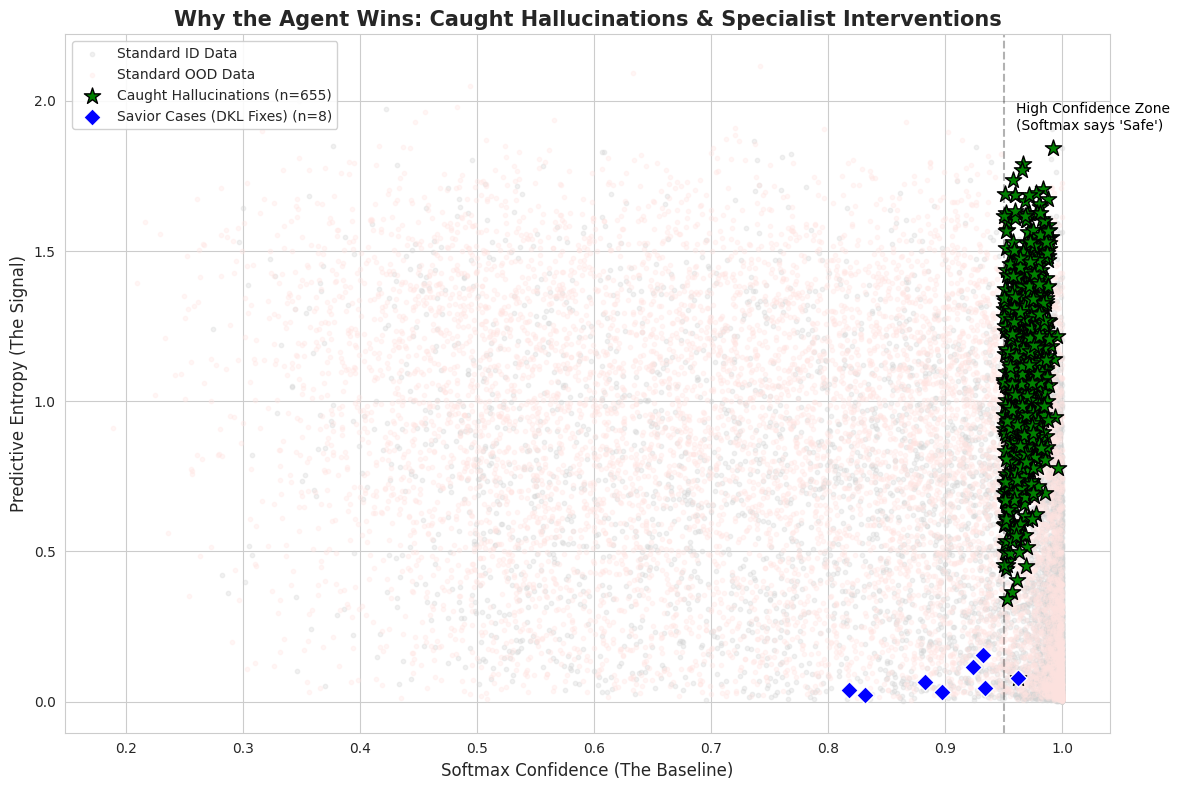


CASE STUDIES: The Agent in Action

[Category 1: The Hallucination Trap]
Scenario: Softmax was >95% confident, but WRONG/OOD.
Total Traps Identified: 2899
Traps Successfully Avoided by Agent: 655 (22.6% Success Rate)
-> Example (Row 5):
   Image Type: ID (Misclassified)
   Softmax Conf: 0.9527 (Super High!)
   Entropy:      1.3710 (The warning sign)
   Agent Action: Abstain

[Category 2: The Savior Case]
Scenario: Softmax Failed, but DKL knew the answer.
Total Opportunities: 417
Agent successfully chose DKL: 8
-> Example (Row 726):
   Softmax Prediction: 0 (Wrong)
   DKL Prediction:     8 (Correct)
   Agent Choice:       Action 1 (Commit DKL)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_agent_heroics(df):
    """
    Visualizes Category 1 (Hallucination Traps) and Category 2 (Savior Cases)
    to prove the Agent is smarter than a simple Softmax threshold.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))

    # --- FILTERS ---

    # 1. The "Hallucination" Trap (High Conf, High Risk)
    # Definition: Softmax is Super Confident (>95%), but WRONG or OOD.
    # Note: 'base_pred' might not be in df, so we infer wrongness via (label != base_pred) logic
    # assuming 'outcome' or 'chosen_pred' tracks this.
    # Let's rely on: Softmax Conf high AND (OOD OR (ID and Wrong))

    # We reconstruct 'base_wrong' boolean for visualization utility
    # (Assuming we have 'base_pred' and 'label' columns from previous steps)
    base_is_wrong = (df['base_pred'] != df['label'])

    mask_hallucination = (df['base_conf'] > 0.95) & ((df['is_ood'] == 1) | base_is_wrong)

    # Did the Agent Catch it? (Action 2 = Abstain, or Action 1 = DKL Correct)
    mask_caught = mask_hallucination & (
        (df['action'] == 2) |
        ((df['action'] == 1) & (df['chosen_pred'] == df['label']))
    )

    # 2. The "Savior" Case
    # Definition: ID data, Softmax Wrong, DKL Right, Agent Chose DKL (Action 1)
    mask_savior = (
        (df['is_ood'] == 0) &
        (df['base_pred'] != df['label']) &
        (df['dkl_pred'] == df['label']) &
        (df['action'] == 1)
    )

    # --- PLOTTING ---

    # Background: All ID Data (Gray)
    plt.scatter(
        df[df['is_ood']==0]['base_conf'],
        df[df['is_ood']==0]['entropy'],
        c='lightgray', alpha=0.3, s=10, label='Standard ID Data'
    )

    # Background: All OOD Data (Red tint, small)
    plt.scatter(
        df[df['is_ood']==1]['base_conf'],
        df[df['is_ood']==1]['entropy'],
        c='mistyrose', alpha=0.3, s=10, label='Standard OOD Data'
    )

    # HIGHLIGHT 1: Caught Hallucinations (Green Stars)
    caught_df = df[mask_caught]
    plt.scatter(
        caught_df['base_conf'],
        caught_df['entropy'],
        c='green', marker='*', s=150, edgecolors='black',
        label=f'Caught Hallucinations (n={len(caught_df)})'
    )

    # HIGHLIGHT 2: Savior Cases (Blue Diamonds)
    savior_df = df[mask_savior]
    plt.scatter(
        savior_df['base_conf'],
        savior_df['entropy'],
        c='blue', marker='D', s=80, edgecolors='white',
        label=f'Savior Cases (DKL Fixes) (n={len(savior_df)})'
    )

    # Annotations
    plt.title("Why the Agent Wins: Caught Hallucinations & Specialist Interventions", fontsize=15, weight='bold')
    plt.xlabel("Softmax Confidence (The Baseline)", fontsize=12)
    plt.ylabel("Predictive Entropy (The Signal)", fontsize=12)
    plt.legend(loc='upper left', frameon=True, framealpha=0.9)

    # Draw the "Danger Zone" annotation
    plt.axvline(x=0.95, color='black', linestyle='--', alpha=0.3)
    plt.text(0.96, df['entropy'].max()*0.9, "High Confidence Zone\n(Softmax says 'Safe')", color='black', fontsize=10)

    plt.tight_layout()
    plt.savefig('hero_plot.png')
    plt.show()

    # --- TEXT REPORT ---
    print("\n" + "="*60)
    print("CASE STUDIES: The Agent in Action")
    print("="*60)

    print(f"\n[Category 1: The Hallucination Trap]")
    print(f"Scenario: Softmax was >95% confident, but WRONG/OOD.")
    print(f"Total Traps Identified: {mask_hallucination.sum()}")
    print(f"Traps Successfully Avoided by Agent: {mask_caught.sum()} ({mask_caught.sum()/mask_hallucination.sum():.1%} Success Rate)")

    if len(caught_df) > 0:
        ex = caught_df.iloc[0]
        print(f"-> Example (Row {ex.name}):")
        print(f"   Image Type: {'OOD' if ex['is_ood'] else 'ID (Misclassified)'}")
        print(f"   Softmax Conf: {ex['base_conf']:.4f} (Super High!)")
        print(f"   Entropy:      {ex['entropy']:.4f} (The warning sign)")
        print(f"   Agent Action: {'Abstain' if ex['action']==2 else 'Switched to DKL'}")

    print(f"\n[Category 2: The Savior Case]")
    print(f"Scenario: Softmax Failed, but DKL knew the answer.")
    print(f"Total Opportunities: {((df['is_ood']==0) & (df['base_pred']!=df['label']) & (df['dkl_pred']==df['label'])).sum()}")
    print(f"Agent successfully chose DKL: {len(savior_df)}")

    if len(savior_df) > 0:
        ex = savior_df.iloc[0]
        print(f"-> Example (Row {ex.name}):")
        print(f"   Softmax Prediction: {int(ex['base_pred'])} (Wrong)")
        print(f"   DKL Prediction:     {int(ex['dkl_pred'])} (Correct)")
        print(f"   Agent Choice:       Action 1 (Commit DKL)")

# Run it
visualize_agent_heroics(df_results)

<Figure size 1500x1000 with 0 Axes>

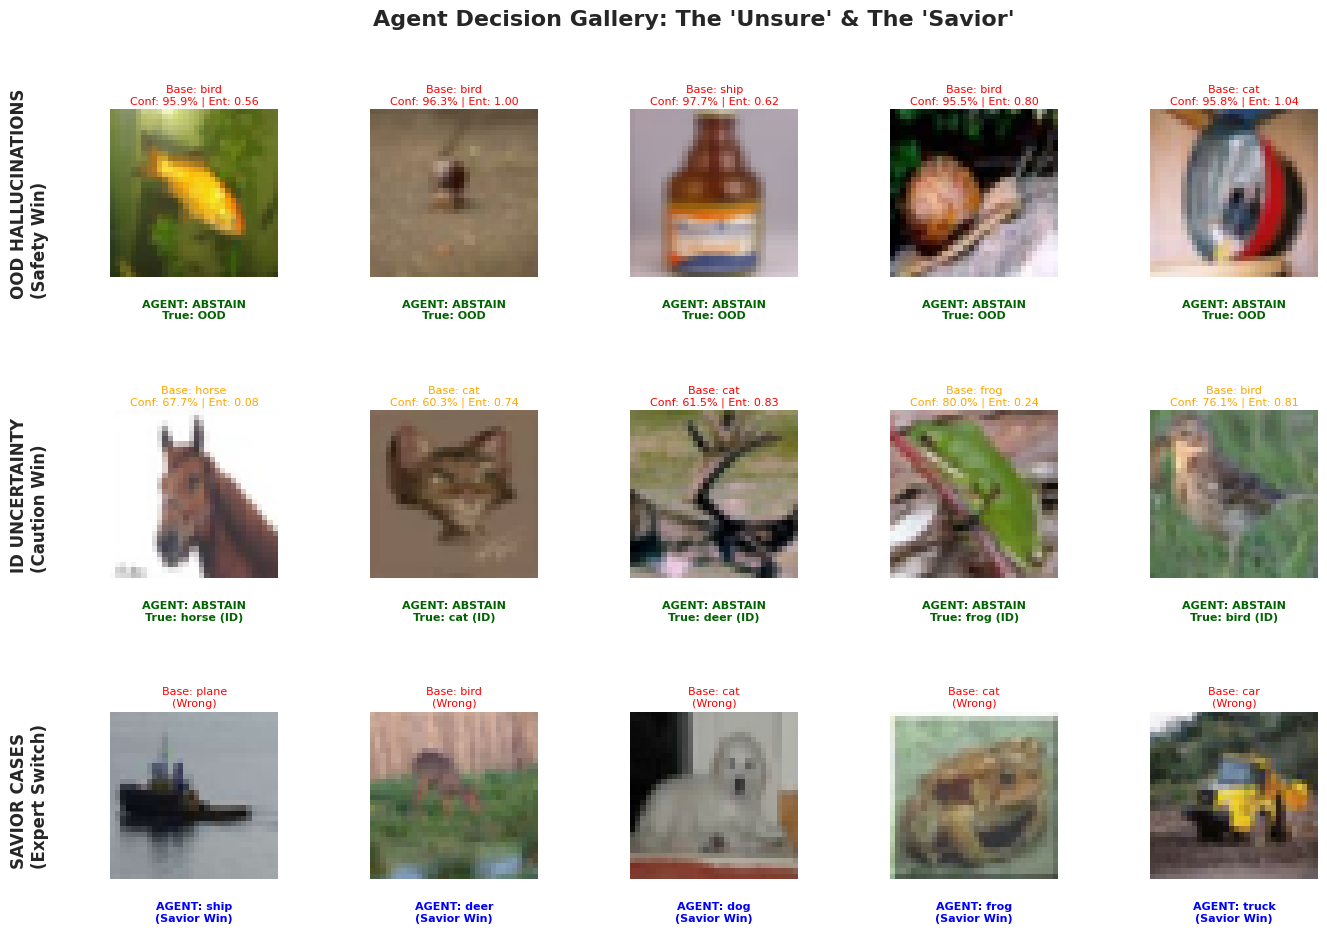

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# Standard CIFAR-10 Classes
CIFAR_CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def unnormalize(tensor):
    """Reverses standard CIFAR normalization for display"""
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = tensor.clone() * std + mean
    return img.clamp(0, 1)

def plot_gallery_row(axes, indices, dataset, df, row_title, class_names=CIFAR_CLASSES):
    """Helper to plot a single row of examples with Uncertainty Metrics"""
    if len(axes) > 0:
        axes[0].text(-0.6, 0.5, row_title, transform=axes[0].transAxes,
                     fontsize=12, weight='bold', rotation=90, va='center')

    for ax, idx in zip(axes, indices):
        # 1. Get Image
        img_tensor, label, _ = dataset[idx]
        row = df.iloc[idx]

        # Display Image
        ax.imshow(unnormalize(img_tensor).permute(1, 2, 0).cpu().numpy())
        ax.axis('off')

        # 2. Extract Metrics
        base_conf = row['base_conf']
        entropy = row['entropy'] # <--- The key metric

        base_pred_idx = int(row['base_pred'])
        dkl_pred_idx = int(row['dkl_pred'])
        label_idx = int(label)

        base_name = class_names[base_pred_idx] if class_names else str(base_pred_idx)
        dkl_name = class_names[dkl_pred_idx] if class_names else str(dkl_pred_idx)

        # 3. Determine True Label String
        if row['is_ood'] == 1:
            true_label_str = "True: OOD"
        else:
            true_name = class_names[label_idx] if class_names else str(label_idx)
            true_label_str = f"True: {true_name} (ID)"

        # 4. Caption Logic

        # Case A: OOD Hallucination (Abstain)
        if row['is_ood'] == 1 and row['action'] == 2:
            # SHOW THE CONTRADICTION: High Conf vs High Entropy
            title_text = f"Base: {base_name}\nConf: {base_conf:.1%} | Ent: {entropy:.2f}"
            title_color = 'red'
            status_text = f"AGENT: ABSTAIN\n{true_label_str}"
            status_color = 'darkgreen'

        # Case B: ID Uncertainty (Abstain)
        elif row['is_ood'] == 0 and row['action'] == 2:
            # SHOW THE UNCERTAINTY
            title_text = f"Base: {base_name}\nConf: {base_conf:.1%} | Ent: {entropy:.2f}"
            title_color = 'red' if base_pred_idx != label_idx else 'orange'
            status_text = f"AGENT: ABSTAIN\n{true_label_str}"
            status_color = 'darkgreen'

        # Case C: Savior (Switch to DKL)
        elif row['action'] == 1:
            title_text = f"Base: {base_name}\n(Wrong)"
            title_color = 'red'
            status_text = f"AGENT: {dkl_name}\n(Savior Win)"
            status_color = 'blue'

        else:
            title_text = "Unknown"
            title_color = 'black'
            status_text = "Unknown"
            status_color = 'black'

        ax.set_title(title_text, fontsize=8, color=title_color, pad=4)
        ax.text(0.5, -0.25, status_text, transform=ax.transAxes,
                ha='center', fontsize=8, weight='bold', color=status_color)

def visualize_hero_gallery_refined(dataset, df, num_images=5):
    plt.figure(figsize=(15, 10))

    # --- FILTER 1: OOD Hallucination Traps ---
    # Softmax > 95% Conf, Is OOD, Agent Abstained
    mask_ood_hallucination = (
        (df['base_conf'] > 0.95) &
        (df['is_ood'] == 1) &
        (df['action'] == 2)
    )
    ood_indices = df[mask_ood_hallucination].index.tolist()

    # --- FILTER 2: ID Uncertainty ---
    mask_id_abstain = (
        (df['is_ood'] == 0) &
        (df['action'] == 2)
    )
    id_abstain_indices = df[mask_id_abstain].index.tolist()

    # --- FILTER 3: Savior Cases ---
    mask_savior = (
        (df['is_ood'] == 0) &
        (df['base_pred'] != df['label']) &
        (df['dkl_pred'] == df['label']) &
        (df['action'] == 1)
    )
    savior_indices = df[mask_savior].index.tolist()

    # Select Random Indices
    sel_ood = np.random.choice(ood_indices, min(num_images, len(ood_indices)), replace=False)
    sel_id_abs = np.random.choice(id_abstain_indices, min(num_images, len(id_abstain_indices)), replace=False)
    sel_savior = np.random.choice(savior_indices, min(num_images, len(savior_indices)), replace=False)

    # Create Subplots
    n_cols = max(len(sel_ood), len(sel_id_abs), len(sel_savior), 1)
    fig, axes = plt.subplots(3, n_cols, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.8, wspace=0.3)

    if n_cols == 1: axes = axes.reshape(3, 1)

    # Plot Row 1
    if len(sel_ood) > 0:
        plot_gallery_row(axes[0, :len(sel_ood)], sel_ood, dataset, df, "OOD HALLUCINATIONS\n(Safety Win)")
        for ax in axes[0, len(sel_ood):]: ax.axis('off')
    else:
        axes[0,0].text(0.5, 0.5, "No OOD Hallucinations Found", ha='center'); axes[0,0].axis('off')

    # Plot Row 2
    if len(sel_id_abs) > 0:
        plot_gallery_row(axes[1, :len(sel_id_abs)], sel_id_abs, dataset, df, "ID UNCERTAINTY\n(Caution Win)")
        for ax in axes[1, len(sel_id_abs):]: ax.axis('off')
    else:
        axes[1,0].text(0.5, 0.5, "No ID Abstentions Found", ha='center'); axes[1,0].axis('off')

    # Plot Row 3
    if len(sel_savior) > 0:
        plot_gallery_row(axes[2, :len(sel_savior)], sel_savior, dataset, df, "SAVIOR CASES\n(Expert Switch)")
        for ax in axes[2, len(sel_savior):]: ax.axis('off')
    else:
        axes[2,0].text(0.5, 0.5, "No Savior Cases Found", ha='center'); axes[2,0].axis('off')

    plt.suptitle(f"Agent Decision Gallery: The 'Unsure' & The 'Savior'", fontsize=16, weight='bold')
    plt.savefig('hero_gallery_final.png')
    plt.show()

# Run it
visualize_hero_gallery_refined(fast_eval_loader.dataset, df_results, num_images=5)